In [1]:
#| default_exp training

In [2]:
#|export 
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [4]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [5]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh, nh), nn.Linear(nh, nh), nn.ReLU(), nn.Linear(nh, nh), nn.ReLU(), nn.Linear(nh, nh), nn.ReLU(), nn.ReLU(), nn.Linear(nh, nh), nn.ReLU(), nn.Linear(nh, nh), nn.ReLU(), nn.Linear(nh, nh), nn.ReLU(), nn.Linear(nh,n_out)]
        self.layers = [l.to('cuda') for l in self.layers] 
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [6]:
x_train,y_train,x_valid,y_valid = tuple(map(lambda x: x.to('cuda'), (x_train,y_train,x_valid,y_valid)))

In [7]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [8]:
v=torch.randn((2,5))

In [9]:
v,v.exp()

(tensor([[-0.49, -0.35,  1.81, -0.78, -0.88],
         [-1.12, -0.28, -0.18,  1.13,  0.65]]),
 tensor([[0.61, 0.70, 6.12, 0.46, 0.41],
         [0.33, 0.76, 0.83, 3.09, 1.91]]))

In [10]:
def softmax(x):
    num = x.exp()
    '''
    assuming rank-2 input: each row is a 1-rank vector of predictions for a single example. sum(1) adds across columns.
    [:, None] is equivalent to keepdim=True, makes sure the result is a column vector so that each row of numerator is all elementwise divided by the corresponding sum of that row
    '''
    denom = x.exp().sum(1)[:,None]
    return (num / denom)

In [11]:
s = softmax(v)
s.sum(1),s.sum(1,keepdim=True)


(tensor([1., 1.]),
 tensor([[1.],
         [1.]]))

In [12]:
import math

In [13]:
l=[1,10,100]
for k in l:
    print(k, math.exp(k), math.exp(-k), sep='\t\t')

1		2.718281828459045		0.36787944117144233
10		22026.465794806718		4.5399929762484854e-05
100		2.6881171418161356e+43		3.720075976020836e-44


In [14]:
def logsumexp(x):
    maxv = x.max(1)[0][:,None]
    return maxv + (x - maxv).exp().sum(1, keepdim=True).log()

In [15]:
def log_softmax(x):
    return x-logsumexp(x)

In [16]:
x=tensor([[10,10,10],
        [-10000,-10000,-100000],
        [100,100,100]])
logsumexp(x),log_softmax(x),log_softmax(x).exp()#,softmax(x),softmax(x).log()

(tensor([[   11.10],
         [-9999.31],
         [  101.10]]),
 tensor([[    -1.10,     -1.10,     -1.10],
         [    -0.69,     -0.69, -90000.70],
         [    -1.10,     -1.10,     -1.10]]),
 tensor([[0.33, 0.33, 0.33],
         [0.50, 0.50, 0.00],
         [0.33, 0.33, 0.33]]))

In [17]:
def nll_loss(logpreds, targ):
    return -logpreds[range(targ.shape[0]), targ].mean()

In [18]:
logp = log_softmax(x)
targ=tensor([0,2,2])
logp,logp.exp(),targ
logp,logp[torch.arange(0,targ.shape[0]),targ],logp[:,targ]

(tensor([[    -1.10,     -1.10,     -1.10],
         [    -0.69,     -0.69, -90000.70],
         [    -1.10,     -1.10,     -1.10]]),
 tensor([    -1.10, -90000.70,     -1.10]),
 tensor([[    -1.10,     -1.10,     -1.10],
         [    -0.69, -90000.70, -90000.70],
         [    -1.10,     -1.10,     -1.10]]))

In [19]:
nll_loss(logp, targ)

tensor(30000.97)

In [20]:
logsmpred=log_softmax(logp)
logsmpred.shape,logsmpred[:5].exp()

(torch.Size([3, 3]),
 tensor([[0.33, 0.33, 0.33],
         [0.50, 0.50, 0.00],
         [0.33, 0.33, 0.33]]))

In [21]:
y_train[:3]

tensor([5, 0, 4], device='cuda:0')

In [22]:
'''
F.cross_entropy(x,y) = F.nll_loss(F.log_softmax(pred), y)
'''
F.cross_entropy(pred, y_train)

tensor(2.31, device='cuda:0', grad_fn=<NllLossBackward0>)

In [23]:
loss_func = F.cross_entropy
bs = 50
#x_train,y_train,x_valid,y_valid = tuple(map(lambda x: x.to('cpu'), (x_train,y_train,x_valid,y_valid)))

In [24]:
#|export
def accuracy(preds, yb):
    return (preds.argmax(dim=1) == yb).float().mean()

In [25]:
#|export
def report(loss, acts, yb): print(f'{loss:.2f}, {accuracy(acts, yb):.2f}')

In [26]:
lr=0.5
epochs = 3

In [27]:
model = Model(m, 500, 10)


In [28]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        idxs=torch.randint(0,x_train.shape[0], (bs,)).to('cuda')
        xb,yb = x_train[idxs],y_train[idxs]
        acts = model(xb)
        loss = loss_func(acts, yb)
        loss.backward()
        for l in model.layers:
            if hasattr(l, 'weight'):
                l.weight.data -= l.weight.grad * lr
                l.bias.data -= l.bias.grad * lr
                l.weight.grad.zero_()
                l.bias.grad.zero_()
    with torch.no_grad():
        report(loss, acts, yb)

1.05, 0.52
0.30, 0.92
0.20, 0.90


In [29]:
loss

tensor(0.20, device='cuda:0', grad_fn=<NllLossBackward0>)

In [30]:
m1=nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [31]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [32]:
m1.named_children()

<generator object Module.named_children at 0x7ff2e1693cf0>

In [33]:
list(m1.parameters())

[Parameter containing:
 tensor([[-0.06,  0.50, -0.55],
         [ 0.45,  0.33,  0.23],
         [-0.28,  0.09,  0.02],
         [ 0.20,  0.45, -0.30]], requires_grad=True),
 Parameter containing:
 tensor([-0.24,  0.27,  0.05,  0.27], requires_grad=True)]

In [34]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [35]:
features_in=m

In [36]:
hidden_layers=nh
features_out=10

In [37]:
model=MLP(features_in, hidden_layers, features_out)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [38]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

pytorch overrides setattr func so submodules etc get registered to be returned later

In [39]:
for name, l in model.named_children():
    print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [40]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [41]:
epochs=5
lr=.1
bs=50

In [42]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, i+bs)
            xb, yb = x_train[s], y_train[s]
            acts = model(xb)
            loss = loss_func(acts, yb)
            loss.backward()
            for p in model.parameters():
                p.data -= p.grad.data * lr
                model.zero_grad()
        print(loss)

In [43]:
model=model.to('cuda')
fit()

tensor(0.63, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.53, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.47, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.43, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.40, device='cuda:0', grad_fn=<NllLossBackward0>)


In [44]:
class MyModule:
    def __init__(self, nin, nhidden, nout):
        self._modules = {}
        self.l1 = nn.Linear(nin, nhidden)
        self.l2 = nn.Linear(nhidden, nout)
    def __setattr__(self, k, v):
        if not k.startswith('_'):
            self._modules[k] = v
        super().__setattr__(k, v)
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()


In [45]:
module = MyModule(features_in, hidden_layers, features_out)
module

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [46]:
[p.shape for p in module.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## registering modules

In [47]:
from functools import reduce

In [48]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [49]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, layer in enumerate(self.layers):
            self.add_module(f'layer_{i}', layer)
    
    def forward(self, x):
        return reduce(lambda val, layer: layer(val), self.layers, x)
    

In [50]:
layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [51]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [52]:
model = model.to('cuda')

In [53]:
model(x_train).shape

torch.Size([50000, 10])

In [54]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.layers = self.layers.to('cuda')
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [55]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [56]:
fit()

tensor(0.70, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.59, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.53, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.49, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.46, device='cuda:0', grad_fn=<NllLossBackward0>)


In [57]:
model=nn.Sequential(*layers).to('cuda')
fit()

tensor(0.44, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.42, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.40, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.39, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.38, device='cuda:0', grad_fn=<NllLossBackward0>)


In [58]:
class Optimizer():
    def __init__(self, params, lr=0.1):
        self.params = list(params)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [59]:
model=nn.Sequential(*layers).to('cuda')

In [60]:
opt = Optimizer(model.parameters())

In [61]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, i+bs)
        xb,yb = x_train[s], y_train[s]
        acts = model(xb)
        loss = loss_func(acts, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(loss)

tensor(0.13, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.11, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.09, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.07, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.06, device='cuda:0', grad_fn=<NllLossBackward0>)


In [62]:
from torch import optim
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)).to('cuda')
    return model, optim.SGD(model.parameters(), lr=lr)

In [63]:
model,opt = get_model()
loss_func(model(x_valid), y_valid)

tensor(2.31, device='cuda:0', grad_fn=<NllLossBackward0>)

In [64]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, i+bs)
        xb,yb = x_train[s], y_train[s]
        acts = model(xb)
        loss = loss_func(acts, yb)
        loss.backward()
        ''' 
        but now using pytorch's optimizer
        '''
        opt.step()
        opt.zero_grad()
    print(f'validation accuracy: {accuracy(model(x_valid), y_valid)}')

validation accuracy: 0.9235999584197998
validation accuracy: 0.9474999904632568
validation accuracy: 0.9566999673843384
validation accuracy: 0.960599958896637
validation accuracy: 0.9643999934196472


## Dataset, DataLoader

In [65]:
#|export
class Dataset():
    def __init__(self, x, y):
        assert (len(x) == len(y))
        self.x=x
        self.y=y
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.x)
        

In [66]:
ds_train=Dataset(x_train, y_train)
ds_valid = Dataset(x_valid, y_valid)

In [67]:
assert(len(ds_train) == len(x_train))
assert(len(ds_valid) == len(x_valid))

In [68]:
xb,yb = ds_train[0:5]
assert xb.shape == (5,784)
assert yb.shape == (5,)

In [69]:
model,opt = get_model()

In [70]:
def report():
    with torch.no_grad():
        acts = model(x_valid)
        vloss=loss_func(acts, y_valid)
        print(f'val loss: {vloss:.2f}, validation accuracy: {accuracy(acts, y_valid):.2f}')

In [71]:
for epoch in range(epochs):
    for i in range(0,n,bs):
        xb,yb = ds_train[i : i+bs]
        acts = model(xb)
        loss = loss_func(acts, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report()

val loss: 0.27, validation accuracy: 0.93
val loss: 0.20, validation accuracy: 0.95
val loss: 0.16, validation accuracy: 0.96
val loss: 0.14, validation accuracy: 0.96
val loss: 0.13, validation accuracy: 0.96


## DataLoader

In [72]:
#|export
class DataLoader():
    def __init__(self, dataset, bs):
        self.dataset = dataset
        self.bs = bs
    
    def __iter__(self):
        for i in range(0, len(self.dataset), self.bs):
            yield self.dataset[i : i+bs]

In [73]:
dl_train = DataLoader(ds_train, bs)
dl_valid = DataLoader(ds_valid, len(ds_valid))

In [74]:
xb, yb = next(iter(dl_train))
tuple(map(lambda t: t.shape, (xb, yb,))),bs

((torch.Size([50, 784]), torch.Size([50])), 50)

## plotting images

tensor([7], device='cuda:0')

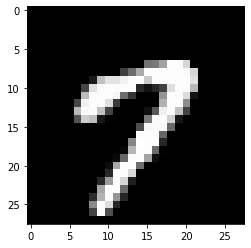

In [75]:
idx=torch.randint(0,50,(1,))
plt.imshow(xb[idx].view(28,28).cpu())
yb[idx]

In [76]:
model,opt = get_model()

In [77]:
def fit():
    for epoch in range(epochs):
        for xb,yb in dl_train:
            acts = model(xb)
            loss = loss_func(acts, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report()

In [78]:
#fit()

## Random sampling

In [79]:
import random

In [80]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.leng = len(ds)
        self.shuffle=shuffle
    
    def __iter__(self):
        idxs = list(range(self.leng))
        if self.shuffle:
            random.shuffle(idxs)
        # return iter(idxs) # the correct solution, below is to experiment with islice and yield
        for i in idxs:
            #print(i)
            yield i

In [81]:
from itertools import islice

In [82]:
islice??

Init signature: islice(self, /, *args, **kwargs)
Docstring:     
islice(iterable, stop) --> islice object
islice(iterable, start, stop[, step]) --> islice object

Return an iterator whose next() method returns selected values from an
iterable.  If start is specified, will skip all preceding elements;
otherwise, start defaults to zero.  Step defaults to one.  If
specified as another value, step determines how many values are
skipped between successive calls.  Works like a slice() on a list
but returns an iterator.
Type:           type
Subclasses:     


In [83]:
sampler=Sampler(ds_train, shuffle=True)
'''
underlying iterator will be called linearly for all the values before and inside the islice range but islice will drop them and only itself will
return those specified by start/step/stop range
'''
sl=islice(sampler, 5,25,2)
sl,list(sl)

(<itertools.islice at 0x7ff2e0a5e950>,
 [32031, 4213, 21756, 19333, 45496, 37313, 30004, 17734, 15700, 17414])

In [84]:
import fastcore.all as fc

In [85]:
for a in True,False:
    for b in True,False:
        print(a,b,a^b)

True True False
True False True
False True True
False False False


In [86]:
fc.chunked??

Signature: fc.chunked(it, chunk_sz=None, drop_last=False, n_chunks=None)
Source:   
def chunked(it, chunk_sz=None, drop_last=False, n_chunks=None):
    "Return batches from iterator `it` of size `chunk_sz` (or return `n_chunks` total)"
    assert bool(chunk_sz) ^ bool(n_chunks)
    if n_chunks: chunk_sz = max(math.ceil(len(it)/n_chunks), 1)
    if not isinstance(it, Iterator): it = iter(it)
    while True:
        res = list(itertools.islice(it, chunk_sz))
        if res and (len(res)==chunk_sz or not drop_last): yield res
        if len(res)<chunk_sz: return
File:      /usr/local/lib/python3.9/dist-packages/fastcore/basics.py
Type:      function


In [87]:
g=fc.chunked(sampler, 5)
next(g)

[31078, 11188, 47057, 40480, 49578]

In [88]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False):
        self.sampler = sampler
        self.bs = bs
        self.drop_last = False
    def __iter__(self):
        while True:
            sl = islice(sampler, self.bs)
            if sl is not None:
                yield list(sl)

batchsampler = BatchSampler(sampler, 4)
list(islice(batchsampler, 3))

[[41845, 42429, 23291, 31074],
 [14084, 4575, 6843, 49737],
 [45676, 13551, 1873, 38467]]

In [89]:
t=torch.randint(0,100,(13,))
it=iter(t)
for i in range(11):
    print(list(islice(it,3)))
t

[tensor(72), tensor(21), tensor(24)]
[tensor(3), tensor(96), tensor(49)]
[tensor(91), tensor(63), tensor(67)]
[tensor(94), tensor(91), tensor(56)]
[tensor(18)]
[]
[]
[]
[]
[]
[]


tensor([72, 21, 24,  3, 96, 49, 91, 63, 67, 94, 91, 56, 18])

In [90]:
'''
given list of tuples (a1,b1),(a2,b2) etc, where each tuple is an a and b that should be paired together,
returns two lists, so a and b are broken out to separate lists, preserving their order so lista[i] matches with listb[i]
'''
def collate(batch):
    xs,ys = zip(*batch)
    '''torch.stack takes a non-tensor collection of tensors and makes it into
    a tensor of tensors. items of the collection must be tensors of same size, 
    and they are each in separate rows of the resultant tensor. the resultant
    tensor has rank which is exactly 1 larger than the constituent tensors.
    torch.stack(list(tensor(1, 1)), list(tensor(2, 2))) will be a
    2x2 tensor([[1, 1], [2, 2]])
    
    
    opposed to torch.cat which concatenates one after the other in the same
    existing dimension, resultant rank equals constituent tensor rank, and 
    constituent tensors needn't be same shape.
    torch.cat(list(tensor(1, 2, 3)), list(tensor(4, 5))) = (5,)-shaped tensor
    tensor([1, 2, 3, 4, 5])
    '''
    
    return torch.stack(xs),torch.stack(ys)

In [91]:
def mk(): return (torch.randint(15,(1,)), torch.randint(15,(1,)),)
ls=[mk(), mk(), mk()]
ls,list(zip(*ls))
x,y=collate(ls)
x.shape,y.shape,(x,y)
''' star operator takes a collection, when given in a context in which a tuple would be appropriate,
and splits it apart into a tuple representing its elements

ls=[1,2,3]
(*ls,4) = (1,2,3,4)
(*ls,) = (1,2,3)
'''
(*ls,) #,list(zip(*ls))

((tensor([4]), tensor([1])),
 (tensor([14]), tensor([10])),
 (tensor([10]), tensor([9])))

In [92]:
class DataLoader():
    def __init__(self, dataset, batchsampler, collate_fn=collate):
        self.dataset=dataset
        self.batchsampler = batchsampler
        self.collate_fn = collate
    def __iter__(self):
        yield from (self.collate_fn(self.dataset[i] for i in b) for b in self.batchsampler)

In [93]:
train_sampler=BatchSampler(Sampler(ds_train, shuffle=True), bs)
valid_sampler=BatchSampler(Sampler(ds_valid, shuffle=True), bs)

In [94]:
train_dl = DataLoader(ds_train, train_sampler)
valid_dl = DataLoader(ds_valid, valid_sampler)

In [95]:
xb,yb = next(iter(train_dl))

tensor([1], device='cuda:0')

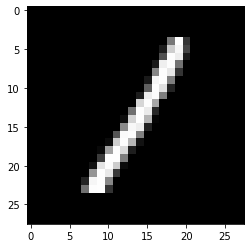

In [96]:
r=torch.randint(0,bs,(1,))
plt.imshow(xb[r].view(28,28).cpu())
yb[r]

In [97]:
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [98]:
model,opt=get_model()
#fit()

In [99]:
import torch.multiprocessing as mp

In [100]:
x,y=ds_train[0]
x.shape,y.shape # a single training pair

xs,ys = ds_train[[1,3,5]]
xs.shape,ys.shape # the three respective pairs of training data indexed at 1, 3, and 5. shaped (3,784) and (3)

(torch.Size([3, 784]), torch.Size([3]))

In [101]:
import fastcore.all as fc

In [102]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate):
        fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as executor:
            yield from executor.map(self.ds.__getitem__, iter(self.batchs))

In [103]:
dl_train = DataLoader(ds_train, batchs=train_sampler, n_workers=4)

In [104]:
xb,yb=next(iter(train_dl))
xb.shape,yb.shape # 50,784 and 50

(torch.Size([50, 784]), torch.Size([50]))

## pytorch dataloader

In [105]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [106]:
train_sampler = BatchSampler(RandomSampler(ds_train), bs, drop_last=False)
valid_sampler = BatchSampler(RandomSampler(ds_valid), bs, drop_last=False)

In [107]:
dl_train = DataLoader(ds_train, batch_sampler=train_sampler, collate_fn=collate)
dl_valid = DataLoader(ds_valid, batch_sampler=valid_sampler, collate_fn=collate)

In [108]:
model,opt=get_model()

In [109]:
#fit()
'''
val loss: 0.13, validation accuracy: 0.96
val loss: 0.11, validation accuracy: 0.97
val loss: 0.10, validation accuracy: 0.97
'''

'\nval loss: 0.13, validation accuracy: 0.96\nval loss: 0.11, validation accuracy: 0.97\nval loss: 0.10, validation accuracy: 0.97\n'

In [110]:
# pytorch to handle creating batchsampler:
dl_train = DataLoader(ds_train, bs, RandomSampler(ds_train), collate_fn=collate)
dl_valid = DataLoader(ds_valid, bs, SequentialSampler(ds_valid), collate_fn=collate)

In [111]:
# and making the sequential and random samplers with pytorch:
dl_train=DataLoader(ds_train, bs, shuffle=True, drop_last=True,num_workers=2)
dl_valid=DataLoader(ds_valid, bs, shuffle=False, num_workers=2)

In [114]:

# and making the sequential and random samplers with pytorch:
#   (note: for this section, switch back to cpu because cuda requires special care for gpu tensors and multiprocessing)
x_train,y_train,x_valid,y_valid = tuple(map(lambda x: x.cpu(), (x_train,y_train,x_valid,y_valid)))

ds_train=Dataset(x_train, y_train)
ds_valid = Dataset(x_valid, y_valid)
# dataloaders, multiprocessing
dl_train=DataLoader(ds_train, bs, shuffle=True, drop_last=True,num_workers=2)
dl_valid=DataLoader(ds_valid, bs, shuffle=False, num_workers=2)

In [115]:
model,opt=get_model()
model=model.cpu()
epochs=2
'''
weird cuda init errors happened whenever I tried to start things with the model, training data, all tensors etc initialized on gpu

has to do with this, with multiprocessing (num_workers) and cuda APIs:
https://pytorch.org/docs/master/notes/multiprocessing.html#cuda-in-multiprocessing
'''
fit()

val loss: 0.25, validation accuracy: 0.93
val loss: 0.19, validation accuracy: 0.95


In [116]:
# back to gpu
x_train,y_train,x_valid,y_valid = tuple(map(lambda x: x.cuda(), (x_train,y_train,x_valid,y_valid)))
ds_train=Dataset(x_train, y_train)
ds_valid = Dataset(x_valid, y_valid)

In [117]:
'''because the dataset object knows how to handle batched indexes already, can just treat the batch 
sampler as the regular sampler and skip collate: the batched indexed returned will just be retrieved
as correct result batches by the vanilla dataset'''
dl_train=DataLoader(ds_train, sampler=train_sampler)
xb,yb=next(iter(dl_train))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

In [118]:
'''model.train and model.eval set configs for things like normalization and dropout to act appropriately
for each phase'''
#|export
def fit(epochs, model, loss_func, opt, dl_train, dl_valid):
    for epoch in range(epochs):
        model.train()
        for xb, yb in dl_train:
            loss=loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()
        with torch.no_grad():
            totloss,totacc,count=0.,0.,0.
            for xb,yb in dl_valid:
                acts= model(xb)
                loss= loss_func(acts,yb)
                n=xb.shape[0]
                count += n
                totloss += loss.item()*n # doing this gets a weighted average of loss across batches: last batch may be smaller
                totacc += accuracy(acts, yb).item() * n
        print(f'epoch: {epoch}, val loss: {totloss/count:2f}, val accuracy: {totacc/count:2f}')

In [119]:
#|export
def get_dls(ds_train, ds_valid, bs, **kwargs):
    return (DataLoader(ds_train, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(ds_valid, batch_size=bs, shuffle=False, **kwargs))

In [120]:
dl_train,dl_valid=get_dls(ds_train, ds_valid, bs)
model,opt=get_model()

In [121]:
fit(3, model, loss_func,opt, dl_train, dl_valid)

epoch: 0, val loss: 0.250112, val accuracy: 0.929800
epoch: 1, val loss: 0.188068, val accuracy: 0.947400
epoch: 2, val loss: 0.157923, val accuracy: 0.956900


In [122]:
!pip install nbdev

In [123]:
import nbdev; nbdev.nbdev_export()